Using device: cpu
L shape: torch.Size([10000, 10000]), L device: cpu


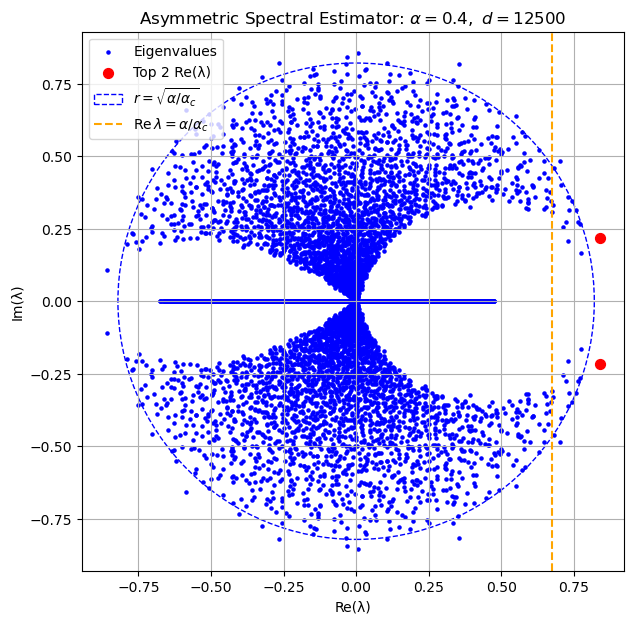

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as besselk
import random
import os

# Set random seed for reproducibility
def set_seed(seed=4):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(4)

# Experiment parameters
n = 5000               # number of samples
p = 2                  # subspace dimension
alpha = 0.4
alpha_c = 0.59375
d = int(n / alpha)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Input matrix X ∈ ℝ^{n×d}
X = torch.randn(n, d, device=device) / np.sqrt(d)

# Ground-truth subspace W* and observations Z = XW*
W_star = torch.randn(d, p, device=device)
Z = X @ W_star
z1, z2 = Z[:, 0], Z[:, 1]
y = z1 * z2  # link function: y = z1 * z2

# Preprocessing function G(y) ∈ ℝ^{n×p×p} (Bessel-based)
y_cpu = y.detach().cpu().numpy()
abs_y = np.abs(y_cpu)
K1 = besselk(1, abs_y)
K0 = besselk(0, abs_y)
lambda_y = abs_y * (K1 / K0) - 1
lambda_y[np.isnan(lambda_y)] = 0  # numerical stability

# Construct G(y): per-sample 2×2 symmetric block
G_y_np = np.zeros((n, p, p), dtype=np.float32)
G_y_np[:, 0, 0] = lambda_y
G_y_np[:, 1, 1] = lambda_y
G_y_np[:, 0, 1] = y_cpu
G_y_np[:, 1, 0] = y_cpu
G_y = torch.tensor(G_y_np, device=device)

# Spectral matrix L ∈ ℝ^{(np)×(np)}
XXT = X @ X.T                      # shape: (n, n)
XXT.fill_diagonal_(0.0)            # remove diagonal entries

# L blocks: (iμ, jν) entries
A = XXT[:, :, None, None]          # shape: (n, n, 1, 1)
G_broadcast = G_y[None, :, :, :]   # shape: (1, n, p, p)
L_blocks = A * G_broadcast         # shape: (n, n, p, p)
L = L_blocks.permute(0, 2, 1, 3).reshape(n * p, n * p)
print(f"L shape: {L.shape}, L device: {L.device}")

# Eigenvalue computation
eigvals = torch.linalg.eigvals(L)
eigvals_np = eigvals.detach().cpu().numpy()
eigvals_real = eigvals_np.real

# Top-2 eigenvalues by largest real part
top2_idx = np.argsort(eigvals_real)[-2:]
top2_vals = eigvals_np[top2_idx]

# Spectrum visualization
plt.figure(figsize=(7, 7))
plt.scatter(eigvals_np.real, eigvals_np.imag, s=5, color='blue', label='Eigenvalues')
plt.scatter(top2_vals.real, top2_vals.imag, color='red', s=50, label='Top 2 Re(λ)')

# Theoretical spectral radius and threshold
r = np.sqrt(alpha / alpha_c)
thresh = alpha / alpha_c
circle = plt.Circle((0, 0), r, color='blue', fill=False, linestyle='--',
                    label=rf'$r = \sqrt{{\alpha / \alpha_c}}$')
plt.gca().add_artist(circle)
plt.axvline(x=thresh, color='orange', linestyle='--',
            label=rf'$\mathrm{{Re}}\,\lambda = \alpha / \alpha_c$')

# Figure settings
plt.xlabel('Re(λ)')
plt.ylabel('Im(λ)')
plt.title(rf'Asymmetric Spectral Estimator: $\alpha = {alpha},\ d = {d}$')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


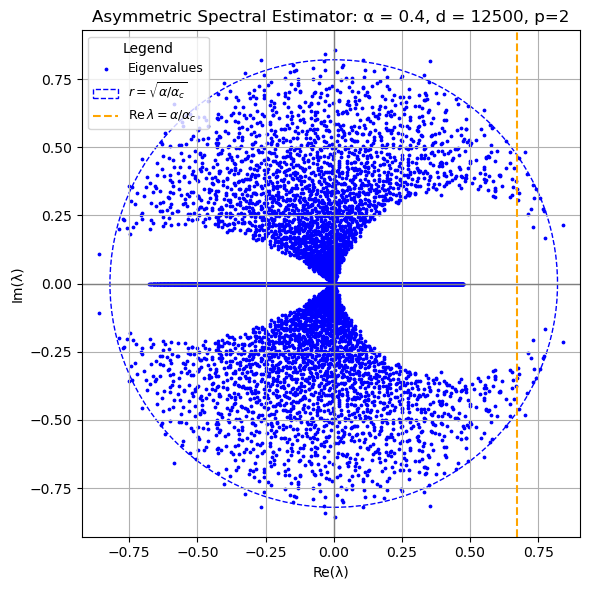

In [ ]:
# Threshold definitions
R = np.sqrt(alpha / alpha_c)        # theoretical spectral radius (blue dashed circle)
thresh_ext = alpha / alpha_c        # external outlier threshold (orange dashed line)

# Select real-valued eigenvalues
real_mask = np.isclose(eigvals_np.imag, 0.0, atol=1e-6)
eigvals_real_only = eigvals_np[real_mask]
real_parts = eigvals_real_only.real

# Top-2 eigenvalues with largest Re(λ)
red_vals = eigvals_real_only[np.argsort(real_parts)[-2:]]

# Visualization
plt.figure(figsize=(6, 6))
plt.scatter(eigvals_np.real, eigvals_np.imag, color="blue", s=3, label="Eigenvalues")

# Theoretical radius and threshold line
circle = plt.Circle((0, 0), R, color="blue", linestyle="--", fill=False,
                    label=r"$r = \sqrt{\alpha/\alpha_c}$")
plt.gca().add_artist(circle)
plt.axvline(thresh_ext, color="orange", linestyle="--",
            label=r"$\mathrm{Re}\,\lambda = \alpha/\alpha_c$")

# Axes and labels
plt.axhline(0, color='gray', linewidth=1)
plt.axvline(0, color='gray', linewidth=1)
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.title(f"Asymmetric Spectral Estimator: α = {alpha}, d = {d}, p={p}")

# Legend and layout
plt.legend(loc='upper left', fontsize=9, title="Legend", title_fontsize=10)
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()
